In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas import Series, DataFrame
from sklearn import datasets, svm
import  scipy.stats as stats
from scipy import interpolate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import  cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from collections import OrderedDict
import time

In [83]:
trainData = np.loadtxt("sat-train.csv",delimiter=',')
testData = np.loadtxt("sat-test.csv",delimiter=',')
X_trainData = trainData[:,:-1]
Y_trainData = trainData[:,-1]

def rearrangeData(xData,size):
    
    x_Rearranged = []
    try:
        xrange
    except NameError:
        xrange = range
    #Rearrange the data according to the spectral feature set
    for i in xrange(size):        
        x1,x2,x3,x4=[],[],[],[]
        rearranged_data = []
        orig_data = xData[i]        
        split_arr = np.hsplit(orig_data,9)
        for i in xrange(9):
            x1.append(split_arr[i][0])
            x2.append(split_arr[i][1])
            x3.append(split_arr[i][2])
            x4.append(split_arr[i][3])
        rearranged_data = np.hstack((x1,x2,x3,x4))
        x_Rearranged.append(orig_data)
    return np.array(x_Rearranged)
    

X_TrainRearranged = rearrangeData(X_trainData,X_trainData.shape[0])
#X_TestRearranged = rearrangeData(testData,testData.shape[0])
X_TrainRearranged

    

array([[  92.,  115.,  120., ...,  107.,  113.,   87.],
       [  84.,  102.,  106., ...,   99.,  104.,   79.],
       [  84.,  102.,   nan, ...,   nan,   nan,   nan],
       ..., 
       [  nan,   75.,  108., ...,   nan,  104.,   85.],
       [  71.,   87.,  108., ...,   91.,  104.,   85.],
       [  71.,   91.,   nan, ...,   91.,   nan,   nan]])

In [61]:
from collections import Counter
Counter(Y_trainData)




2000

In [3]:
def replace_missing_values(Data,replace_by):
#     print "here"
    #Replacing Missing Values or NaN Values using several methods:    
    inds = np.where(np.isnan(Data))#indexes to be replaced
    
    if replace_by == 'zero':
        Data[np.isnan(Data)] = 0
        
    if replace_by == 'colmean':
        col_mean = stats.nanmean(Data,axis=0)
        Data[inds[0],inds[1]]=np.take(col_mean,inds[1])
        
    if replace_by == 'rowmean':
        row_mean = stats.nanmean(Data,axis=1)
        Data[inds[0],inds[1]]=np.take(row_mean,inds[0])
#         print Data
        
    if replace_by == 'rowmedian':
        row_median = stats.nanmedian(Data,axis=1)
        Data[inds[0],inds[1]] = np.take(row_median,inds[0])
   
        
    if replace_by == 'colmedian':
        col_median = stats.nanmedian(Data,axis=0)
        Data[inds[0],inds[1]] = np.take(col_median,inds[1])
        
    if replace_by == 'rowmode':       
        XTrain_Mask = np.ma.masked_array(Data,np.isnan(Data))        
        row_mode = stats.mstats.mode(XTrain_Mask, axis=1)[0]
        row_mode_modify = np.hstack(row_mode)
        Data[inds[0],inds[1]] =np.take(row_mode_modify,inds[0])
        
    if replace_by == 'colmode':
        XTrain_Mask = np.ma.masked_array(Data,np.isnan(Data))
        col_mode = stats.mstats.mode(XTrain_Mask, axis=0)[0]
        Data[inds[0],inds[1]] =np.take(col_mode,inds[1])
        
        
    if replace_by == 'rowmax':
        row_max = np.nanmax(Data, axis=1)
        Data[inds[0],inds[1]]=np.take(row_max,inds[0])
        
    if replace_by == 'colmax':
        col_max = np.nanmax(Data, axis=0)
        Data[inds[0],inds[1]]=np.take(col_max,inds[1])
        
    if replace_by == 'rowmean_per_spectral':
        x_spectrum =  np.hsplit(Data,4)
        x1,x2,x3,x4 = x_spectrum[0],x_spectrum[1],x_spectrum[2],x_spectrum[3]
        X1 = replace_missing_values(x1,'rowmean')
        X2 = replace_missing_values(x2,'rowmean')
        X3 = replace_missing_values(x3,'rowmean')
        X4 = replace_missing_values(x4,'rowmean')
        rowmean_per_spectral = np.hstack((X1,X2,X3,X4))
        Data[inds[0],inds[1]] = np.take(rowmean_per_spectral,inds[0])
        
    if replace_by == 'rowmedian_per_spectral':
        x_spectrum =  np.hsplit(Data,4)
        x1,x2,x3,x4 = x_spectrum[0],x_spectrum[1],x_spectrum[2],x_spectrum[3]
        X1 = replace_missing_values(x1,'rowmedian')
        X2 = replace_missing_values(x2,'rowmedian')
        X3 = replace_missing_values(x3,'rowmedian')
        X4 = replace_missing_values(x4,'rowmedian')
        rowmedian_per_spectral = np.hstack((X1,X2,X3,X4))
        Data[inds[0],inds[1]] = np.take(rowmedian_per_spectral,inds[0])
    
    if replace_by == 'rowmode_per_spectral':
        x_spectrum =  np.hsplit(Data,4)
        x1,x2,x3,x4 = x_spectrum[0],x_spectrum[1],x_spectrum[2],x_spectrum[3]
        X1 = replace_missing_values(x1,'rowmode')
        X2 = replace_missing_values(x2,'rowmode')
        X3 = replace_missing_values(x3,'rowmode')
        X4 = replace_missing_values(x4,'rowmode')
        rowmode_per_spectral = np.hstack((X1,X2,X3,X4))
        Data[inds[0],inds[1]] = np.take(rowmode_per_spectral,inds[0])
    
    if replace_by == 'interpolate_missing':
        XTrain_Mask = np.isnan(Data)
        Data[XTrain_Mask] = np.interp(np.flatnonzero(XTrain_Mask), np.flatnonzero(~XTrain_Mask), Data[~XTrain_Mask])
        
    assert(np.isfinite(Data.all()))
    return Data

#X_TrainRearranged=replace_missing_values(X_TrainRearranged,"colmean")

The optimal number of neighbors is 5


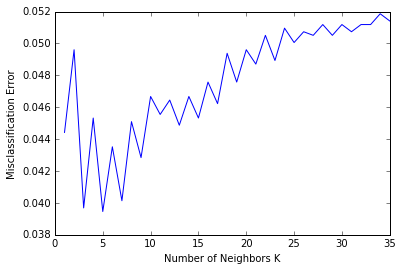

The optimal number of neighbors is 5


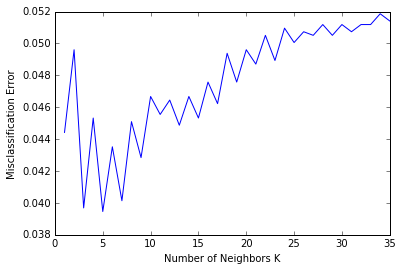

The optimal number of neighbors is 5


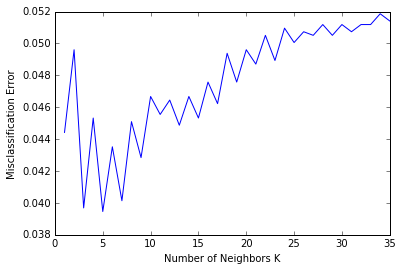

The optimal number of neighbors is 5


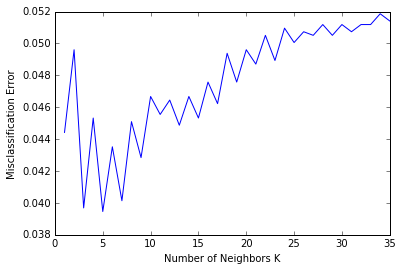

The optimal number of neighbors is 5


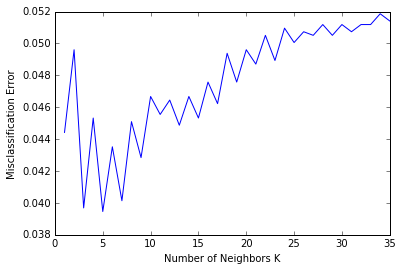

The optimal number of neighbors is 5


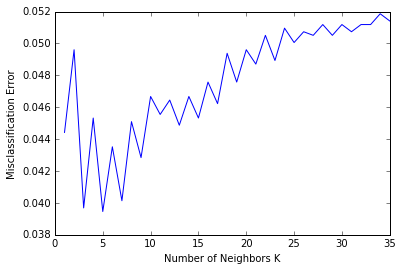

The optimal number of neighbors is 5


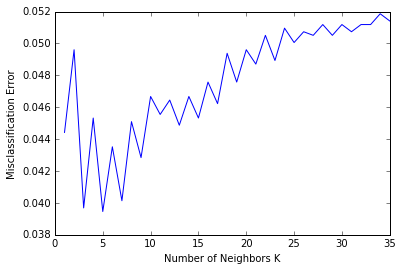

The optimal number of neighbors is 5


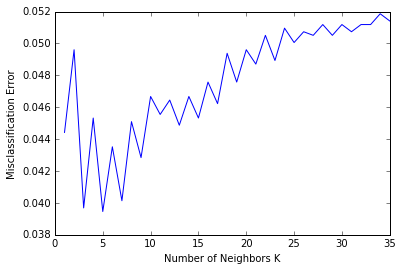

The optimal number of neighbors is 5


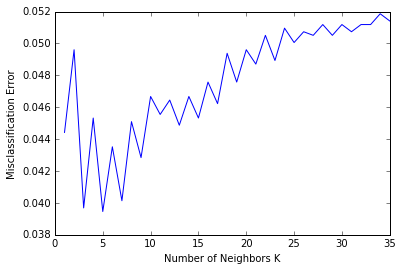

The optimal number of neighbors is 5


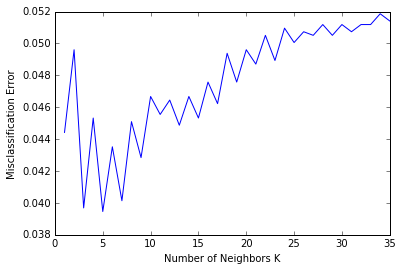

The optimal number of neighbors is 5


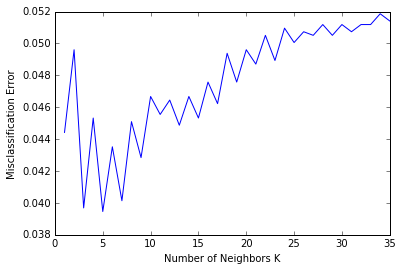

The optimal number of neighbors is 5


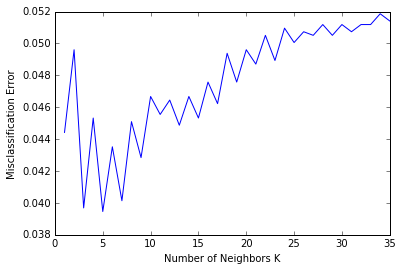

The optimal number of neighbors is 5


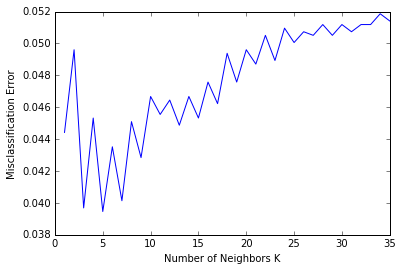

In [62]:
def FindBestK_KNearestNeighborsClassifier(trainData,trainLabel,replace_by):
    tra=replace_missing_values(trainData,replace_by)
    #Measure with K Nearest Neighbours Classifiers with Cross Validation
    neighbors = list(range(1,36))      
    cv_scores = []    
    # perform 4-fold cross validation    
    for k in neighbors:
        for scoring_method in ["accuracy", "precision", "recall"]:
            knn = KNeighborsClassifier(n_neighbors=k)
            scores= cross_val_score(knn,tra,trainLabel,scoring=scoring_method, cv=4).mean()
            #print("score in KNN")
            if(scoring_method=="accuracy"):
                #print(scores)
                cv_scores.append(scores)
    MSE = [1 - x for x in cv_scores]
    #print(MSE)
    
    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print("The optimal number of neighbors is %d" %optimal_k)
    
    #plot misclassification error vs k
    plt.plot(neighbors, MSE)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    return cv_scores


knn_zero,knn_rowmean,knn_colmean,knn_rowmedian,knn_colmedian,knn_rowmax,knn_colmax,knn_rowmode,knn_colmode,knn_rowmean_per_spectral,knn_rowmedian_per_spectral,knn_rowmode_per_spectral,knn_interpolate_missing=[],[],[],[],[],[],[],[],[],[],[],[],[]
knn_zero.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'zero'))
knn_rowmean.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'rowmean'))
knn_colmean.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'colmean'))
knn_rowmedian.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'rowmedian'))
knn_colmedian.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'colmedian'))
knn_rowmax.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'rowmax'))
knn_colmax.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'colmax'))
knn_rowmode.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'rowmode'))
knn_colmode.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'colmode'))
knn_rowmean_per_spectral.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'rowmean_per_spectral'))
knn_rowmedian_per_spectral.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'rowmedian_per_spectral'))
knn_rowmode_per_spectral.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'rowmode_per_spectral'))
knn_interpolate_missing.append(FindBestK_KNearestNeighborsClassifier(X_TrainRearranged,Y_trainData,'interpolate_missing'))











In [101]:
#Measure with Classifiers: Naive Bayes, Decision Tree, K Nearest Neighbors, Random Forest using Cross Validation
def CrossValidation_NaiveBayesClassifier(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:
        scores=cross_val_score(GaussianNB(),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores


def CrossValidation_DecisionTreeClassifier(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:        
        scores = cross_val_score(DecisionTreeClassifier(),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores


def CrossValidation_KNearestNeighbors(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:
        scores = cross_val_score(KNeighborsClassifier(n_neighbors=5),trainData,trainLabel,scoring=score, cv=4).mean()   
        cv_scores.append(scores)
    return cv_scores


def CrossValidation_RandomForestn50(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=50),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores

def CrossValidation_RandomForestn68(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=68),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores


def CrossValidation_LogisticRegression(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(LogisticRegression(),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores

def CrossValidation_RandomForestn63(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=63),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores

def CrossValidation_RandomForestn54(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=54),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores

def CrossValidation_RandomForestn109(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=109),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores

def CrossValidation_RandomForestn150(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=150),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores

def CrossValidation_RandomForestn159(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=159),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores

def CrossValidation_RandomForestn152(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=152),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores

def CrossValidation_RandomForestn66(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=66),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores

def CrossValidation_RandomForestn108(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=83),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores
def CrossValidation_RandomForestn114(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=114),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores
def CrossValidation_RandomForestn155(trainData,trainLabel):
    cv_scores= []
    for score in ["accuracy", "precision", "recall"]:       
        scores = cross_val_score(RandomForestClassifier(n_estimators=155),trainData,trainLabel,scoring=score, cv=4).mean()
        cv_scores.append(scores)
    return cv_scores


In [102]:
def ClassifierScore(replacement_result,inputLabels,classifiers):    
    if(classifiers=="naive bayes"):
#         print replacement_result
        accuracy_score=CrossValidation_NaiveBayesClassifier(replacement_result,inputLabels) 
    elif(classifiers=="knearestneighbors"):
        accuracy_score=CrossValidation_KNearestNeighbors(replacement_result,inputLabels)
    elif(classifiers=="random forest n=50"):
        accuracy_score=CrossValidation_RandomForestn50(replacement_result,inputLabels)
    elif(classifiers=="decision tree"):
        accuracy_score=CrossValidation_DecisionTreeClassifier(replacement_result,inputLabels)
    elif(classifiers=="Logistic Regression"):
        accuracy_score=CrossValidation_LogisticRegression(replacement_result,inputLabels)
    elif(classifiers=="random forest n=68"):
        accuracy_score=CrossValidation_RandomForestn68(replacement_result,inputLabels)
    elif(classifiers=="random forest n=63"):
        accuracy_score=CrossValidation_RandomForestn63(replacement_result,inputLabels)
    elif(classifiers=="random forest n=54"):
        accuracy_score=CrossValidation_RandomForestn54(replacement_result,inputLabels)
    elif(classifiers=="random forest n=109"):
        accuracy_score=CrossValidation_RandomForestn109(replacement_result,inputLabels)
    elif(classifiers=="random forest n=150"):
        accuracy_score=CrossValidation_RandomForestn150(replacement_result,inputLabels)
    elif(classifiers=="random forest n=159"):
        accuracy_score=CrossValidation_RandomForestn159(replacement_result,inputLabels)
    elif(classifiers=="random forest n=152"):
        accuracy_score=CrossValidation_RandomForestn152(replacement_result,inputLabels)
    elif(classifiers=="random forest n=66"):
        accuracy_score=CrossValidation_RandomForestn66(replacement_result,inputLabels)
    elif(classifiers=="random forest n=108"):
        accuracy_score=CrossValidation_RandomForestn83(replacement_result,inputLabels)
    elif(classifiers=="random forest n=114"):
        accuracy_score=CrossValidation_RandomForestn114(replacement_result,inputLabels)
    elif(classifiers=="random forest n=155"):
        accuracy_score=CrossValidation_RandomForestn155(replacement_result,inputLabels)
    
    return accuracy_score

In [108]:
rf_zero,rf_rowmean,rf_colmean,rf_rowmedian,rf_colmedian,rf_rowmax,rf_colmax,rf_rowmode,rf_colmode,rf_rowmeanperspectral,rf_rowmedianperspectral,rf_rowmodeperspectral,rf_interpolate=[],[],[],[],[],[],[],[],[],[],[],[],[]

def FindBestEstimatorRandomForest(inputData,inputLabels,replace_by): 

    clfs = [ ("RandomForestClassifier, max_features=None",RandomForestClassifier(warm_start=True, max_features=None, oob_score=True))]


    error_rate = OrderedDict((label, []) for label, _ in clfs)


    min_estimators = 50
    max_estimators = 200
    #replacement_method = ["zero",'rowmean',"colmean",'rowmedian','colmedian','rowmax','colmax','rowmode','colmode','rowmean_per_spectral','rowmedian_per_spectral','rowmode_per_spectral','interpolate_missing']

    for label, clf in clfs:
            
            replacement_result = []
            replacement_result = replace_missing_values(inputData,replace_by) 
            for i in range(min_estimators, max_estimators + 1):
                clf.set_params(n_estimators=i)
                clf.fit(replacement_result,inputLabels)
                oob_error = 1 - clf.oob_score_
                error_rate[label].append((i, oob_error))


    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    print(xs[ys.index(min(ys))])

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()



95


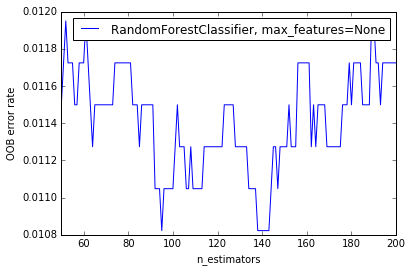

In [109]:
rf_zero.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"zero"))

95


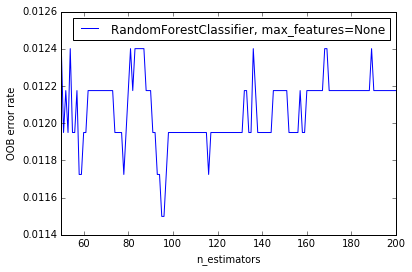

In [110]:
rf_interpolate.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"interpolate_missing"))

73


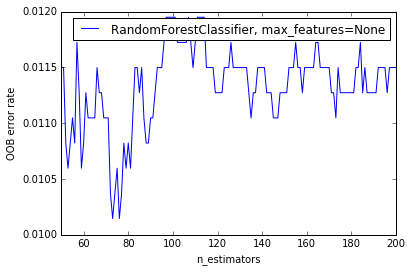

In [111]:
rf_rowmean.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"rowmean"))

63


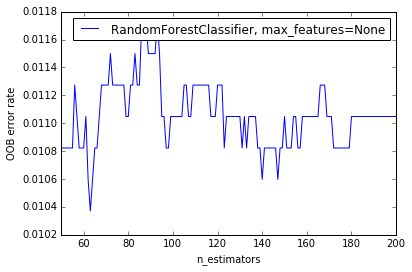

In [112]:
rf_colmean.append(FindBestEstimatorRandomForest(X_TrainRearranged,Y_trainData,"colmean"))

177


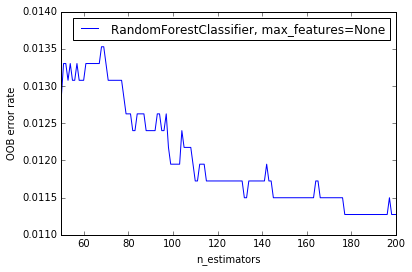

In [98]:
rf_rowmedian.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"rowmedian"))

69


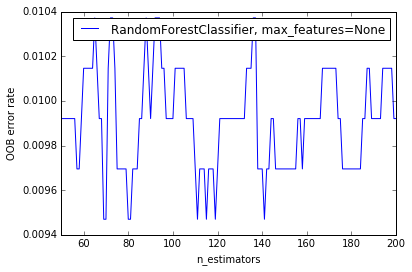

In [100]:
rf_colmedian.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"colmedian"))

58


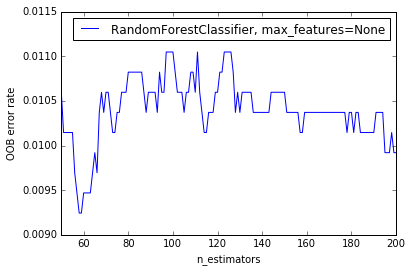

In [60]:
rf_rowmax.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"rowmax"))

69


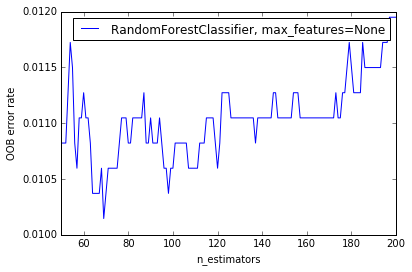

In [34]:
rf_colmax.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"colmax"))

147


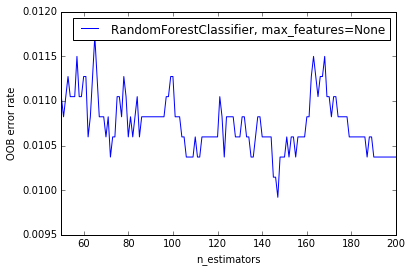

In [62]:
rf_rowmode.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"rowmode"))

56


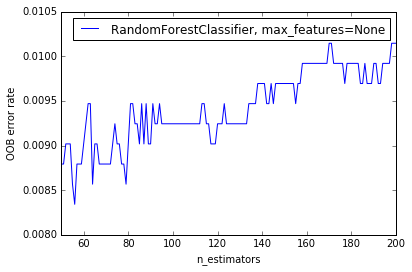

In [35]:
rf_colmode.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"colmode"))

64


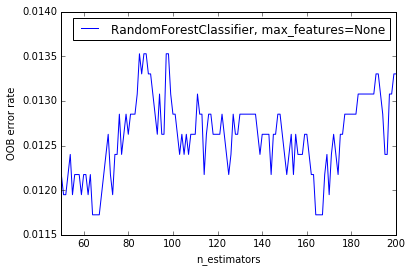

In [48]:
rf_rowmeanperspectral.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"rowmean_per_spectral"))

55


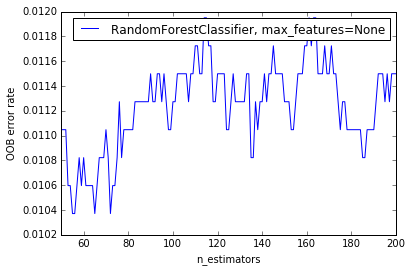

In [49]:
rf_rowmedianperspectral.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"rowmedian_per_spectral"))

66


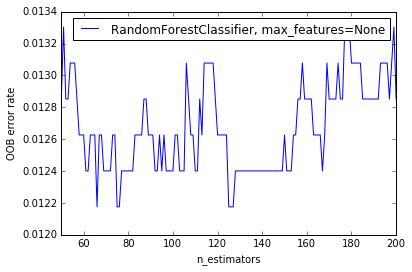

In [135]:
rf_rowmodeperspectral.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"rowmode_per_spectral"))

99


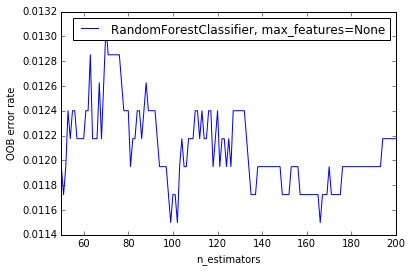

In [50]:
rf_interpolate.append(FindBestEstimatorRandomForest(X_trainData,Y_trainData,"interpolate_missing"))

In [7]:
score_accuracynb,score_accuracyknn,score_accuracyRF,score_accuracyDT,score_accuracylg,scorerf_50,scorerf_68=[],[],[],[],[],[],[]

def Preprocessing(inputData,inputLabels,classifiers): 
    accuracy_score = []
    replacement_method = ["zero",'rowmean',"colmean",'rowmedian','colmedian','rowmax','colmax','rowmode','colmode','rowmean_per_spectral','rowmedian_per_spectral','rowmode_per_spectral','interpolate_missing']
    for replace in replacement_method:
        arranged_data= rearrangeData(inputData,inputData.shape[0])
        replacement_result = []
        replacement_result = replace_missing_values(arranged_data,replace)        
        accuracy_score.append(ClassifierScore(replacement_result,inputLabels,classifiers)[0])
#         print replace,accuracy_score
#     print accuracy_score
    return accuracy_score

In [8]:
score_accuracynb.append(Preprocessing(X_trainData,Y_trainData,"naive bayes"))
print("NAIVE-BAYES:",score_accuracynb[0])
score_accuracynb[0].index(max(score_accuracynb[0]))



NAIVE-BAYES: [0.97857942726559533, 0.96911225190678185, 0.9842161523862849, 0.95152884343067723, 0.9846672124690341, 0.93168219978970879, 0.98241130168981716, 0.93596554120699371, 0.98624561757592133, 0.98196085197253846, 0.98173522020358539, 0.98218607683117787, 0.96527976711708918]


8

In [9]:
score_accuracyknn.append(Preprocessing(X_trainData,Y_trainData,"knearestneighbors"))
print("KNN:",score_accuracyknn[0])
score_accuracyknn[0].index(max(score_accuracyknn[0]))

KNN: [0.9605392619623494, 0.97542017558993854, 0.98263774727939768, 0.97497033623813045, 0.98263754382424084, 0.9711372410829674, 0.97677600075522553, 0.97181311911404233, 0.98353966398973935, 0.97542058250025221, 0.97609727435195459, 0.97632270266575083, 0.97519596800708352]


8

In [17]:
scorerf_50.append(Preprocessing(X_trainData,Y_trainData,"random forest n=50"))
print("random forest n=50",scorerf_50[0])
scorerf_50[0].index(max(scorerf_50[0]))



random forest n=50 [0.98827508276555776, 0.98602059617243887, 0.98782402268280856, 0.9866958638380432, 0.98782361577249489, 0.98782422613796528, 0.98872573593799329, 0.98692169906215299, 0.98827467585524409, 0.9866958638380432, 0.98669667765867053, 0.98782361577249489, 0.98714651701047873]


6

In [64]:
scorerf_68.append(Preprocessing(X_trainData,Y_trainData,"random forest n=68"))
print("random forest n=68",scorerf_68[0])
scorerf_68[0].index(max(scorerf_68[0]))

random forest n=68 [0.98872593939315023, 0.98669606729319992, 0.98850030762419716, 0.98647043552424685, 0.98737255568974547, 0.98737336951037302, 0.98737255568974547, 0.98804924754144796, 0.98985328441728804, 0.98737275914490241, 0.98692190251730993, 0.98714733083110606, 0.98669647420351381]


8

In [14]:
score_accuracyDT.append(Preprocessing(X_trainData,Y_trainData,"decision tree"))
print("Decision tree",score_accuracyDT[0])
score_accuracyDT[0].index(max(score_accuracyDT[0]))

Decision tree [0.97541997213478171, 0.97835399895179909, 0.98308901081730382, 0.97271361163828596, 0.98263652654845646, 0.9765477240692334, 0.97519454382098547, 0.97406780916231817, 0.98444137724492409, 0.97113540998655568, 0.97384339812430631, 0.97226173773490943, 0.97519495073129925]


8

In [15]:
score_accuracylg.append(Preprocessing(X_trainData,Y_trainData,"Logistic Regression"))
print("Logistic Regression",score_accuracylg)
score_accuracylg[0].index(max(score_accuracylg[0]))



Logistic Regression [[0.9614401613969068, 0.97699898760713955, 0.9785782065346541, 0.97609707089679776, 0.97790171813810867, 0.97496992932781668, 0.96820504536236174, 0.97654853788986073, 0.9785782065346541, 0.97429242365548696, 0.97451805542444003, 0.97451785196928309, 0.97519434036582864]]


2

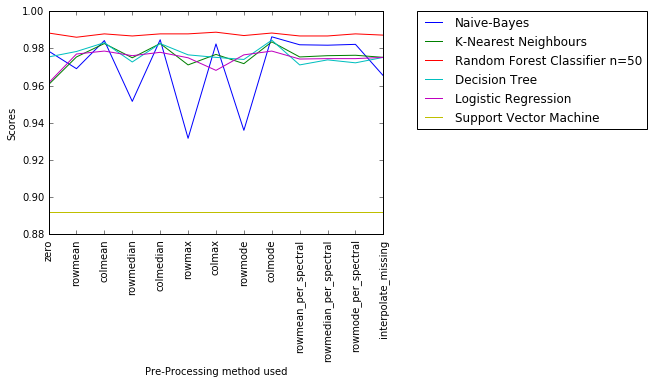

In [106]:
# ### Plotting the Results

# In[ ]:
import matplotlib.pyplot as plt
%matplotlib inline

get_ipython().magic(u'matplotlib inline')
plt.plot(score_accuracynb[0], label = "Naive-Bayes")
plt.plot(score_accuracyknn[0], label = "K-Nearest Neighbours")
plt.plot(scorerf_50[0], label = "Random Forest Classifier n=50")
plt.plot(score_accuracyDT[0], label = "Decision Tree")
plt.plot(score_accuracylg[0], label = "Logistic Regression")
#plt.plot(scorerf_68[0], label = "Random Forest Classifier n=68")
labels = ["zero",'rowmean',"colmean",'rowmedian','colmedian','rowmax','colmax','rowmode','colmode','rowmean_per_spectral','rowmedian_per_spectral','rowmode_per_spectral','interpolate_missing']
plt.xticks(np.arange(len(labels)), labels, rotation='vertical')

plt.ylabel('Scores')
plt.xlabel('Pre-Processing method used')
plt.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
plt.show()

In [68]:
scorerf_63,scorerf_54,scorerf_109,scorerf_150,scorerf_159,scorerf_152,scorerf_66,scorerf_83,scorerf_114,=[],[],[],[],[],[],[],[]

def Preprocessing(inputData,inputLabels,classifiers): 
    accuracy_score = []
    replacement_method = ["zero",'rowmean',"colmean",'rowmedian','colmedian','rowmax','colmax','rowmode','colmode','rowmean_per_spectral','rowmedian_per_spectral','rowmode_per_spectral','interpolate_missing']
    for replace in replacement_method:
        arranged_data= rearrangeData(inputData,inputData.shape[0])
        replacement_result = []
        replacement_result = replace_missing_values(arranged_data,replace)        
        accuracy_score.append(ClassifierScore(replacement_result,inputLabels,classifiers)[0])
#         print replace,accuracy_score
#     print accuracy_score
    return accuracy_score

In [69]:
scorerf_63.append(Preprocessing(X_trainData,Y_trainData,"random forest n=63"))
print("Random Forest n=63",scorerf_63)
scorerf_63[0].index(max(scorerf_63[0]))

Random Forest n=63 [[0.98669606729319992, 0.98692169906215299, 0.98782361577249489, 0.98647043552424685, 0.98759818745869854, 0.98692251288278054, 0.98804924754144796, 0.9860201892621252, 0.98804904408629102, 0.98759839091385548, 0.98714733083110606, 0.98759798400354182, 0.98714753428626301]]


6

In [70]:
scorerf_54.append(Preprocessing(X_trainData,Y_trainData,"random forest n=54"))
print("Random Forest n=54",scorerf_54)
scorerf_54[0].index(max(scorerf_54[0]))

Random Forest n=54 [[0.98850010416904022, 0.98759839091385548, 0.98872532902767962, 0.98737296260005913, 0.98850030762419716, 0.98850030762419716, 0.98827467585524409, 0.98669647420351381, 0.98827447240008715, 0.98782361577249467, 0.98692210597246688, 0.98827487931040081, 0.98692210597246688]]


2

In [168]:
scorerf_50.append(Preprocessing(X_trainData,Y_trainData,"random forest n=50"))
print("Random Forest n=50",scorerf_50)
scorerf_50[0].index(max(scorerf_50[0]))

Random Forest n=50 [[0.98737316605521608, 0.98827508276555776, 0.98940222433453884, 0.98669627074835686, 0.98714773774141995, 0.98759879782416915, 0.98895136770694636, 0.98827548967587153, 0.98827487931040103, 0.98647104588971746, 0.98692149560699627, 0.98759818745869854, 0.98804945099660468]]


2

In [169]:
scorerf_68.append(Preprocessing(X_trainData,Y_trainData,"random forest n=68"))
print("Random Forest n=68",scorerf_68)
scorerf_68[0].index(max(scorerf_68[0]))

Random Forest n=68 [[0.98850010416904044, 0.98737255568974547, 0.98872573593799329, 0.98759818745869854, 0.98804945099660468, 0.9878242261379655, 0.98850030762419716, 0.98804945099660468, 0.98737296260005913, 0.98759818745869854, 0.98737255568974547, 0.98669606729319992, 0.98759879782416915]]


2

In [71]:
scorerf_109.append(Preprocessing(X_trainData,Y_trainData,"random forest n=109"))
print("Random Forest n=109",scorerf_109)
scorerf_109[0].index(max(scorerf_109[0]))

Random Forest n=109 [[0.98624561757592133, 0.98804965445176163, 0.98759859436901221, 0.98737316605521608, 0.98804924754144796, 0.98782442959312222, 0.98872553248283657, 0.98647104588971746, 0.98759798400354182, 0.98737255568974547, 0.98737275914490241, 0.98714712737594934, 0.98782341231733795]]


6

In [72]:
scorerf_150.append(Preprocessing(X_trainData,Y_trainData,"random forest n=150"))
print("Random Forest n=150",scorerf_150)
scorerf_150[0].index(max(scorerf_150[0]))

Random Forest n=150 [[0.98692169906215321, 0.98669606729319992, 0.98692169906215321, 0.98714733083110606, 0.98714733083110606, 0.98804965445176163, 0.98782361577249489, 0.98737316605521608, 0.98872573593799329, 0.98737275914490241, 0.98759839091385548, 0.98647084243456074, 0.98782402268280856]]


8

In [73]:
scorerf_152.append(Preprocessing(X_trainData,Y_trainData,"random forest n=152"))
print("Random Forest n=152",scorerf_152)
scorerf_152[0].index(max(scorerf_152[0]))

Random Forest n=152 [[0.98714733083110628, 0.98804924754144796, 0.98782381922765161, 0.9866958638380432, 0.98827467585524409, 0.98804965445176163, 0.98827487931040103, 0.98759879782416915, 0.98737296260005913, 0.98804884063113407, 0.98827467585524409, 0.98782361577249489, 0.98737275914490241]]


6

In [74]:
scorerf_159.append(Preprocessing(X_trainData,Y_trainData,"random forest n=159"))
print("Random Forest n=159",scorerf_159)
scorerf_159[0].index(max(scorerf_159[0]))

Random Forest n=159 [[0.98579435403801519, 0.98692190251730993, 0.98850030762419716, 0.98692169906215299, 0.98737275914490241, 0.9882752862207147, 0.98804945099660468, 0.98827508276555776, 0.98759839091385548, 0.98737255568974547, 0.9873721487794318, 0.98759839091385548, 0.98850051107935388]]


12

In [98]:
scorerf_114.append(Preprocessing(X_trainData,Y_trainData,"random forest n=114"))
print("Random Forest n=114",scorerf_114)
scorerf_114[0].index(max(scorerf_114[0]))

Random Forest n=114 [[0.98759798400354182, 0.98827508276555776, 0.98782381922765161, 0.98872593939315023, 0.98827487931040103, 0.98737336951037302, 0.98782361577249489, 0.98782381922765161, 0.98759818745869854, 0.98714712737594934, 0.98737275914490241, 0.98692169906215299, 0.98737275914490241]]


3

In [103]:
scorerf_155=[]
scorerf_155.append(Preprocessing(X_trainData,Y_trainData,"random forest n=155"))
print("Random Forest n=155",scorerf_155)
scorerf_155[0].index(max(scorerf_155[0]))

Random Forest n=155 [[0.98872573593799329, 0.98804945099660468, 0.98759818745869854, 0.98647063897940379, 0.9882752862207147, 0.98759839091385548, 0.98737296260005913, 0.98782361577249489, 0.98759839091385548, 0.98669667765867053, 0.98759839091385548, 0.98737316605521608, 0.98827487931040103]]


0

In [91]:
scorerf_66.append(Preprocessing(X_trainData,Y_trainData,"random forest n=66"))
print("Random Forest n=66",scorerf_66)
scorerf_66[0].index(max(scorerf_66[0]))

Random Forest n=66 [[0.98737235223458875, 0.98759818745869854, 0.98737275914490241, 0.98669627074835686, 0.98804965445176163, 0.98692169906215321, 0.98827467585524409, 0.98804904408629102, 0.98804924754144796, 0.98782422613796528, 0.98759859436901243, 0.98804965445176163, 0.98759859436901221]]


6

In [90]:
scorerf_108=[]
scorerf_108.append(Preprocessing(X_trainData,Y_trainData,"random forest n=108"))
print("Random Forest n=108",scorerf_108)
scorerf_108[0].index(max(scorerf_108[0]))

Random Forest n=108 [[0.9871469239207924, 0.98714733083110606, 0.98782402268280856, 0.98601957889665459, 0.98759839091385548, 0.98737316605521608, 0.98624500721045072, 0.98714773774141995, 0.98714753428626301, 0.98692210597246688, 0.98714733083110628, 0.98759778054838487, 0.98827487931040103]]


12

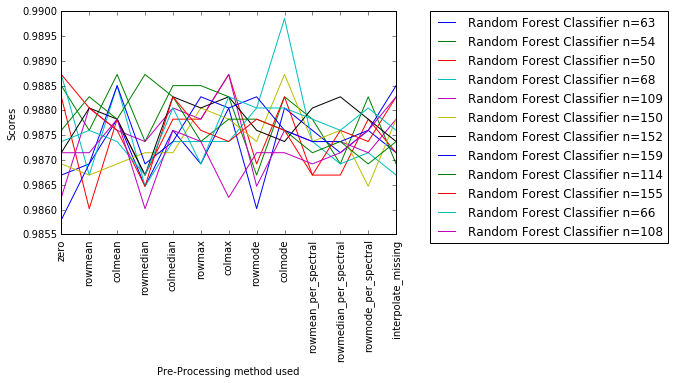

In [104]:
# ### Plotting the Results

# In[ ]:

get_ipython().magic(u'matplotlib inline')
plt.plot(scorerf_63[0], label = "Random Forest Classifier n=63")
plt.plot(scorerf_54[0], label = "Random Forest Classifier n=54")
plt.plot(scorerf_50[0], label = "Random Forest Classifier n=50")
plt.plot(scorerf_68[0], label = "Random Forest Classifier n=68")
plt.plot(scorerf_109[0], label = "Random Forest Classifier n=109")
plt.plot(scorerf_150[0], label = "Random Forest Classifier n=150")
plt.plot(scorerf_152[0], label = "Random Forest Classifier n=152")
plt.plot(scorerf_159[0], label = "Random Forest Classifier n=159")
plt.plot(scorerf_114[0], label = "Random Forest Classifier n=114")
plt.plot(scorerf_155[0], label = "Random Forest Classifier n=155")
plt.plot(scorerf_66[0], label = "Random Forest Classifier n=66")
plt.plot(scorerf_108[0], label = "Random Forest Classifier n=108")

labels = ["zero",'rowmean',"colmean",'rowmedian','colmedian','rowmax','colmax','rowmode','colmode','rowmean_per_spectral','rowmedian_per_spectral','rowmode_per_spectral','interpolate_missing']
plt.xticks(np.arange(len(labels)), labels, rotation='vertical')

plt.ylabel('Scores')
plt.xlabel('Pre-Processing method used')
plt.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
plt.show()



In [35]:
# print X_TestRearranged
# print Y_trainData
Data_replaced_Train = replace_missing_values(X_TrainRearranged,'rowmedian')
print(Data_replaced_Train)
clf = RandomForestClassifier(n_estimators=68)
clf.fit(Data_replaced_Train, Y_trainData)
# pred = clf.predict_proba(Data_replaced_Test)

[[  92.  115.  120. ...,  107.  113.   87.]
 [  84.  102.  106. ...,   99.  104.   79.]
 [  84.  102.  120. ...,  120.  120.  120.]
 ..., 
 [  79.   75.  108. ...,   79.  104.   85.]
 [  71.   87.  108. ...,   91.  104.   85.]
 [  71.   91.  104. ...,   91.  104.  104.]]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=68, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
testData = np.loadtxt("sat-test.csv",delimiter=',')
# print testData

rearranged_test_data= rearrangeData(testData,testData.shape[0])
# print rearranged_test_data
# print "-------------"
Data_replaced_Test = replace_missing_values(rearranged_test_data,'colmedian')
# print Data_replaced_Test
pred = clf.predict(Data_replaced_Test)
# print pred



In [37]:
def writePrediction(Y_testData):
    y= open("Prediction_colmedian68.csv","w")
    y.write("ID,Expected" + "\n")
    try:
        xrange
    except NameError:
        xrange = range
    for i in xrange(len(Y_testData)):
        y.write(str(i+1) + "," + str(int(Y_testData[i]))+ "\n")
    y.close()

In [38]:
writePrediction(pred)

In [39]:
check_pred= pd.read_csv('Prediction_colmedian68.csv')
check_pred

,ID,Expected
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [40]:
check_pred['Expected'].value_counts()

0    1777
1     223
Name: Expected, dtype: int64